In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

In [3]:
# importing the data
raw_csv_data = pd.read_excel("https://timeseries-mlmodel.s3.amazonaws.com/CallCenterData.xlsx")

In [4]:
# check point of data
df_comp = raw_csv_data.copy()

In [5]:
df_comp.head()

,month,Healthcare,Telecom,Banking,Technology,Insurance,#ofphonelines,#noofchannels
0,2010-01-31,631,8,6,2,19,1,4
1,2010-02-28,633,9,7,3,27,1,3
2,2010-03-31,766,4,4,2,24,1,1
3,2010-04-30,768,12,6,3,32,1,1
4,2010-05-31,1003,2,7,2,42,1,4


In [6]:
df_comp.describe()

,Healthcare,Telecom,Banking,Technology,Insurance,#ofphonelines,#noofchannels
count,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000
mean,9856.704545,2411.856061,514.204545,112.454545,651.681818,2.250000,2.537879
std,6221.071304,1714.759241,392.882978,69.680773,395.949633,1.867255,1.161766
min,631.000000,2.000000,4.000000,2.000000,19.000000,0.000000,1.000000
25%,3744.250000,608.750000,119.000000,39.750000,363.500000,1.000000,1.000000
50%,9651.500000,2613.500000,486.000000,130.500000,581.000000,2.000000,3.000000
75%,15590.750000,4000.500000,901.500000,171.250000,997.750000,3.000000,4.000000
max,23602.000000,5138.000000,1310.000000,229.000000,1535.000000,11.000000,4.000000


In [ ]:
df_comp.isna().sum()

month            0
Healthcare       0
Telecom          0
Banking          0
Technology       0
Insurance        0
#ofphonelines    0
#noofchannels    0
dtype: int64

## Setting date as Index

In [ ]:
# taken as a date time field
df_comp.month.describe()

count                     132
unique                    132
top       2010-01-31 00:00:00
freq                        1
first     2010-01-31 00:00:00
last      2020-12-31 00:00:00
Name: month, dtype: object

In [ ]:
df_comp.set_index("month", inplace=True)

In [ ]:
df_comp.head(6)

,Healthcare,Telecom,Banking,Technology,Insurance,#ofphonelines,#noofchannels
month,,,,,,,
2010-01-31,631,8,6,2,19,1,4
2010-02-28,633,9,7,3,27,1,3
2010-03-31,766,4,4,2,24,1,1
2010-04-30,768,12,6,3,32,1,1
2010-05-31,1003,2,7,2,42,1,4
2010-06-30,1046,5,13,2,44,1,2


In [ ]:
# seeting the frequency as monthly
df_comp.asfreq('M')

,Healthcare,Telecom,Banking,Technology,Insurance,#ofphonelines,#noofchannels
month,,,,,,,
2010-01-31,631,8,6,2,19,1,4
2010-02-28,633,9,7,3,27,1,3
2010-03-31,766,4,4,2,24,1,1
2010-04-30,768,12,6,3,32,1,1
2010-05-31,1003,2,7,2,42,1,4
...,...,...,...,...,...,...,...
2020-08-31,20257,4486,1111,212,371,4,3
2020-09-30,19207,4474,1020,135,362,3,1
2020-10-31,23414,5138,1310,188,523,3,4


In [ ]:
# seeting the frequency as monthly
df_comp = df_comp.asfreq('M')

In [ ]:
# checking for the null values
df_comp.isna().sum()

Healthcare       0
Telecom          0
Banking          0
Technology       0
Insurance        0
#ofphonelines    0
#noofchannels    0
dtype: int64

## Time Series Visualization

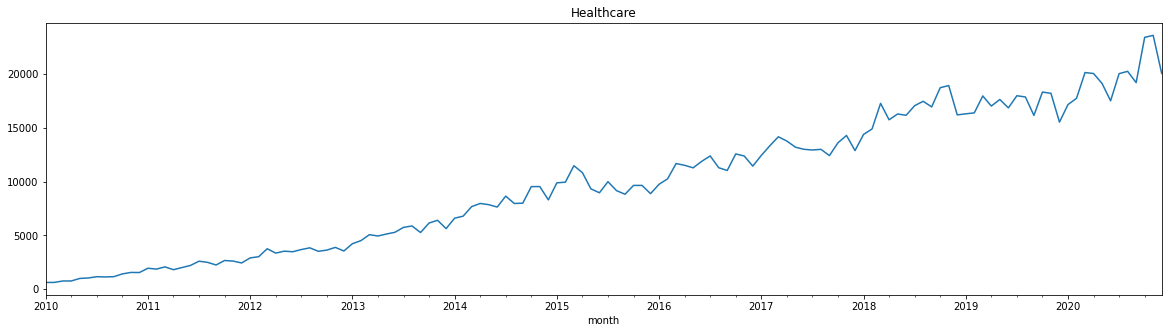

In [ ]:
df_comp.Healthcare.plot(figsize=(20,5), title="Healthcare")
plt.show()

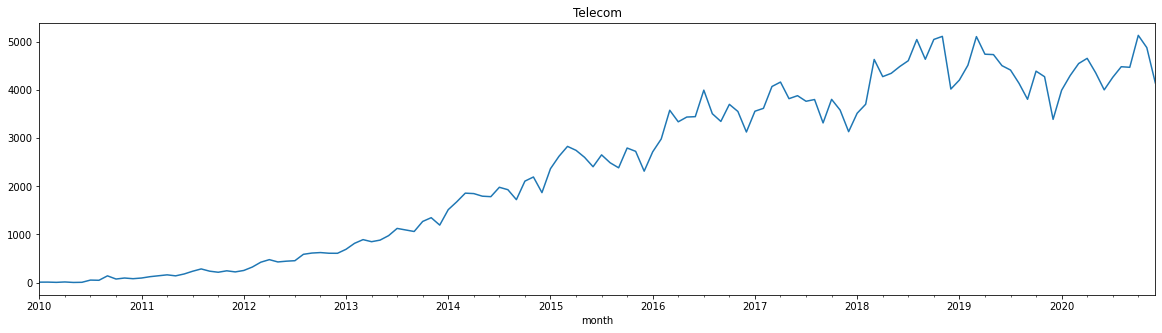

In [ ]:
df_comp.Telecom.plot(figsize=(20,5), title="Telecom")
plt.show()

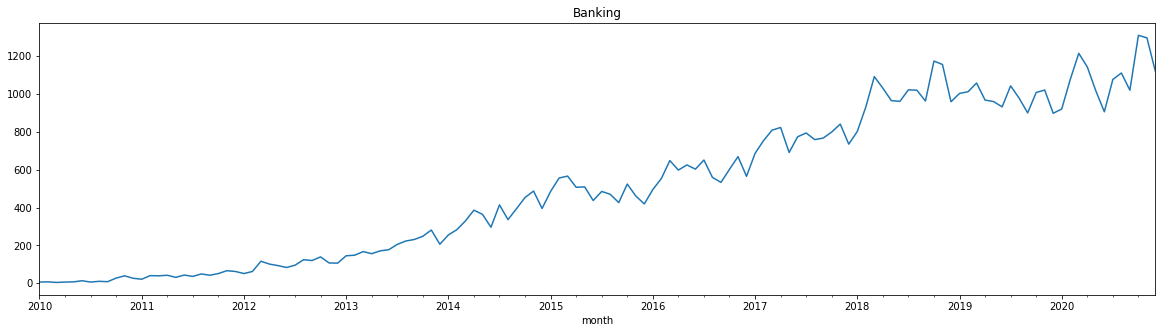

In [ ]:
df_comp.Banking.plot(figsize=(20,5), title="Banking")
plt.show()

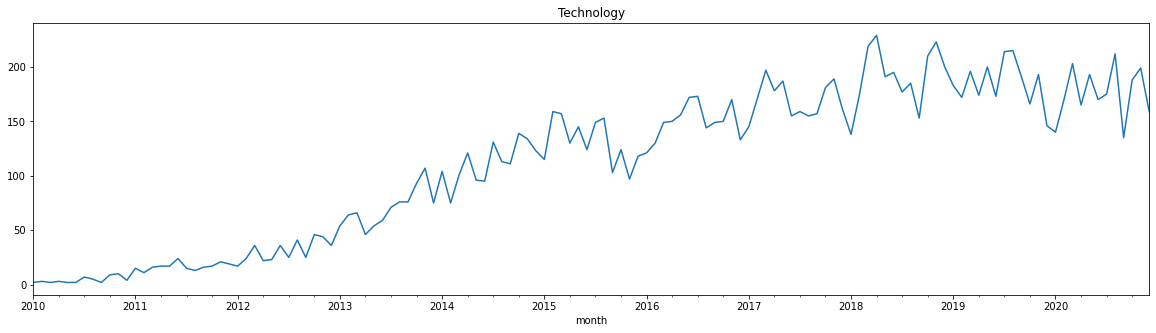

In [ ]:
df_comp.Technology.plot(figsize=(20,5), title="Technology")
plt.show()

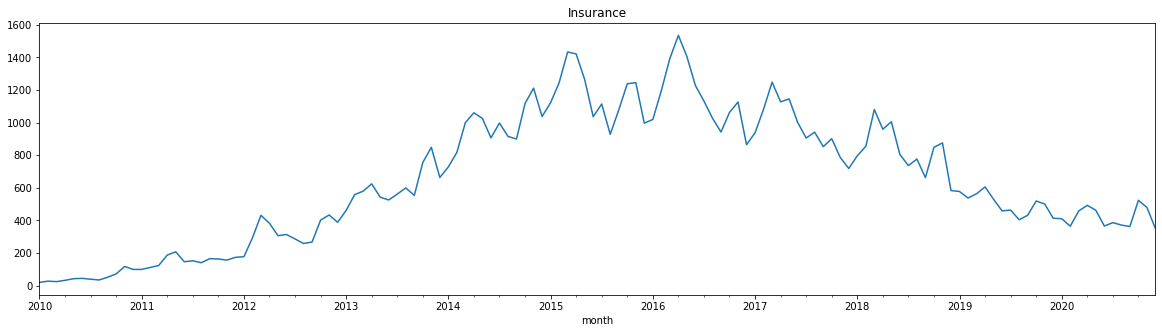

In [ ]:
df_comp.Insurance.plot(figsize=(20,5), title="Insurance")
plt.show()

## Setting the training format

In [7]:
data = df_comp.Healthcare

In [8]:
#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
target_data = []

# Number of days we want to look into the future based on the past days.
n_past = 5  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (?)
#refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(len(data)):
    temp = []
    for j in range(n_past + 1):
        try:
            temp.append(data[i+j])
        except Exception as e:
            continue
    if len(temp) > 5:
        target_data.append(temp)

len(target_data)
target_data

[[631, 633, 766, 768, 1003, 1046],
 [633, 766, 768, 1003, 1046, 1165],
 [766, 768, 1003, 1046, 1165, 1143],
 [768, 1003, 1046, 1165, 1143, 1169],
 [1003, 1046, 1165, 1143, 1169, 1424],
 [1046, 1165, 1143, 1169, 1424, 1562],
 [1165, 1143, 1169, 1424, 1562, 1552],
 [1143, 1169, 1424, 1562, 1552, 1952],
 [1169, 1424, 1562, 1552, 1952, 1872],
 [1424, 1562, 1552, 1952, 1872, 2076],
 [1562, 1552, 1952, 1872, 2076, 1817],
 [1552, 1952, 1872, 2076, 1817, 2017],
 [1952, 1872, 2076, 1817, 2017, 2214],
 [1872, 2076, 1817, 2017, 2214, 2607],
 [2076, 1817, 2017, 2214, 2607, 2498],
 [1817, 2017, 2214, 2607, 2498, 2254],
 [2017, 2214, 2607, 2498, 2254, 2671],
 [2214, 2607, 2498, 2254, 2671, 2619],
 [2607, 2498, 2254, 2671, 2619, 2441],
 [2498, 2254, 2671, 2619, 2441, 2913],
 [2254, 2671, 2619, 2441, 2913, 3024],
 [2671, 2619, 2441, 2913, 3024, 3763],
 [2619, 2441, 2913, 3024, 3763, 3359],
 [2441, 2913, 3024, 3763, 3359, 3538],
 [2913, 3024, 3763, 3359, 3538, 3485],
 [3024, 3763, 3359, 3538, 3485, 368

## Train Test Split

In [9]:
import warnings
warnings.filterwarnings("ignore")

In [10]:
from sklearn.preprocessing import MinMaxScaler
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(target_data)
target_data_scaled = scaler.transform(target_data)


In [19]:
import pickle
pickle.dump(scaler, open("min-max-scaler.pkl", "wb"))

In [17]:
data_df = pd.DataFrame(target_data_scaled, columns=["t-4","t-3","t-2","t-1","t","Y"])

In [20]:
data_df.head()

,t-4,t-3,t-2,t-1,t,Y
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000102,0.006777,0.000103,0.010377,0.001903,0.005276
2,0.006918,0.006879,0.012159,0.012276,0.007168,0.004300
3,0.007021,0.018854,0.014366,0.017531,0.006195,0.005453
4,0.019064,0.021046,0.020471,0.016559,0.007345,0.016758


In [21]:
# train set split
test_size = 20

train = data_df[:-test_size]
test = data_df[-test_size:]

In [26]:
X, Y = train.drop("Y", axis=1).values, train["Y"]
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.1, random_state=0)


X_test, Y_test = test.drop("Y", axis=1).values, test["Y"]

## Neural Networks (Dense)

In [23]:
epochs = 100
lr = 0.0003
adam = optimizers.Adam(lr)

In [27]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               600       
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 701
Trainable params: 701
Non-trainable params: 0
_________________________________________________________________


In [28]:
mlp_history = model_mlp.fit(X_train, Y_train, validation_data=(X_valid, Y_valid), 
                            epochs=epochs, verbose=2)

Epoch 1/100
3/3 - 1s - loss: 0.1376 - val_loss: 0.1381 - 1s/epoch - 347ms/step
Epoch 2/100
3/3 - 0s - loss: 0.1240 - val_loss: 0.1245 - 60ms/epoch - 20ms/step
Epoch 3/100
3/3 - 0s - loss: 0.1122 - val_loss: 0.1117 - 36ms/epoch - 12ms/step
Epoch 4/100
3/3 - 0s - loss: 0.1014 - val_loss: 0.0998 - 32ms/epoch - 11ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0900 - val_loss: 0.0888 - 37ms/epoch - 12ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0805 - val_loss: 0.0786 - 35ms/epoch - 12ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0714 - val_loss: 0.0692 - 29ms/epoch - 10ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0630 - val_loss: 0.0606 - 32ms/epoch - 11ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0554 - val_loss: 0.0527 - 33ms/epoch - 11ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0483 - val_loss: 0.0456 - 35ms/epoch - 12ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0420 - val_loss: 0.0392 - 31ms/epoch - 10ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0363 - val_loss: 0.0336 - 49ms/epoch - 16ms/step
Epoch 13/100
3/3 - 0s - loss: 0.0313 -

In [31]:
mlp_pred = model_mlp.predict(X_test)

In [30]:
pickle.dump(model_mlp, open("../Output/model.pkl", "wb"))

INFO:tensorflow:Assets written to: ram://62cf50de-a6dc-4331-ab60-ffddd0f98f97/assets


In [32]:
model = pickle.load(open("../Output/model.pkl", "rb"))

In [33]:
mlp_pred = model_mlp.predict(X_test)

In [34]:
mlp_pred

array([[0.7090929 ],
       [0.72332805],
       [0.729132  ],
       [0.74171036],
       [0.74124277],
       [0.7304382 ],
       [0.7458531 ],
       [0.7477884 ],
       [0.7215952 ],
       [0.73185366],
       [0.7348731 ],
       [0.7412813 ],
       [0.75754017],
       [0.78829646],
       [0.7995905 ],
       [0.8229527 ],
       [0.81393474],
       [0.799358  ],
       [0.8432687 ],
       [0.88355756]], dtype=float32)

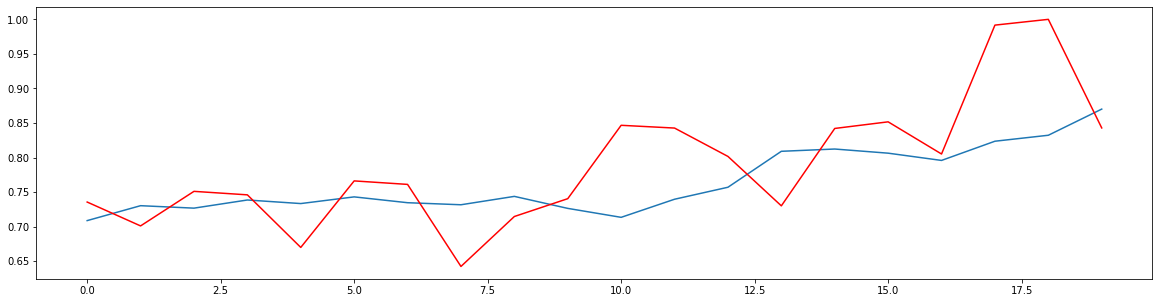

In [ ]:
# plot
plt.figure(figsize=(20,5))
plt.plot(mlp_pred)
plt.plot(Y_test.values, color='red')
plt.show()

## CNN

In [ ]:
X_train_series = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (96, 5, 1)
Validation set shape (11, 5, 1)


In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 64)             192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 50)                6450      
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 6,693
Trainable params: 6,693
Non-trainable params: 0
____________________________________________________

In [ ]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/100
3/3 - 1s - loss: 0.1472 - val_loss: 0.1319 - 946ms/epoch - 315ms/step
Epoch 2/100
3/3 - 0s - loss: 0.1054 - val_loss: 0.0808 - 61ms/epoch - 20ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0632 - val_loss: 0.0421 - 51ms/epoch - 17ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0321 - val_loss: 0.0179 - 53ms/epoch - 18ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0130 - val_loss: 0.0068 - 159ms/epoch - 53ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0051 - val_loss: 0.0051 - 74ms/epoch - 25ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0048 - val_loss: 0.0073 - 61ms/epoch - 20ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0063 - val_loss: 0.0081 - 78ms/epoch - 26ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0063 - val_loss: 0.0067 - 63ms/epoch - 21ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0049 - val_loss: 0.0045 - 65ms/epoch - 22ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0035 - val_loss: 0.0030 - 63ms/epoch - 21ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0028 - val_loss: 0.0025 - 55ms/epoch - 18ms/step
Epoch 13/100
3/3 - 0s - loss: 0.00

Epoch 99/100
3/3 - 0s - loss: 0.0013 - val_loss: 7.0325e-04 - 76ms/epoch - 25ms/step
Epoch 100/100
3/3 - 0s - loss: 0.0013 - val_loss: 7.0777e-04 - 96ms/epoch - 32ms/step


In [ ]:
X_test_series = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
cnn_pred = model_cnn.predict(X_test_series)

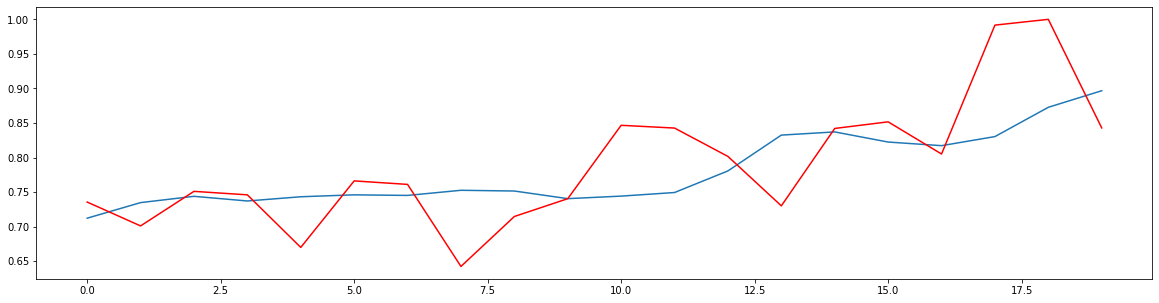

In [ ]:
# plot
plt.figure(figsize=(20,5))
plt.plot(cnn_pred)
plt.plot(Y_test.values, color='red')
plt.show()

## LSTM

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(90, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mse', optimizer=adam)
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90)                33120     
                                                                 
 dense_6 (Dense)             (None, 1)                 91        
                                                                 
Total params: 33,211
Trainable params: 33,211
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/100
3/3 - 2s - loss: 0.1512 - val_loss: 0.1527 - 2s/epoch - 530ms/step
Epoch 2/100
3/3 - 0s - loss: 0.1329 - val_loss: 0.1296 - 51ms/epoch - 17ms/step
Epoch 3/100
3/3 - 0s - loss: 0.1112 - val_loss: 0.1068 - 49ms/epoch - 16ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0916 - val_loss: 0.0864 - 54ms/epoch - 18ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0728 - val_loss: 0.0671 - 52ms/epoch - 17ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0536 - val_loss: 0.0487 - 90ms/epoch - 30ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0369 - val_loss: 0.0324 - 76ms/epoch - 25ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0232 - val_loss: 0.0204 - 101ms/epoch - 34ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0147 - val_loss: 0.0148 - 74ms/epoch - 25ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0112 - val_loss: 0.0149 - 70ms/epoch - 23ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0120 - val_loss: 0.0154 - 75ms/epoch - 25ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0114 - val_loss: 0.0123 - 99ms/epoch - 33ms/step
Epoch 13/100
3/3 - 0s - loss: 0.0086 

Epoch 99/100
3/3 - 0s - loss: 0.0012 - val_loss: 6.3704e-04 - 121ms/epoch - 40ms/step
Epoch 100/100
3/3 - 0s - loss: 0.0012 - val_loss: 5.7705e-04 - 127ms/epoch - 42ms/step


In [ ]:
X_test_series = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
lstm_pred = model_lstm.predict(X_test_series)

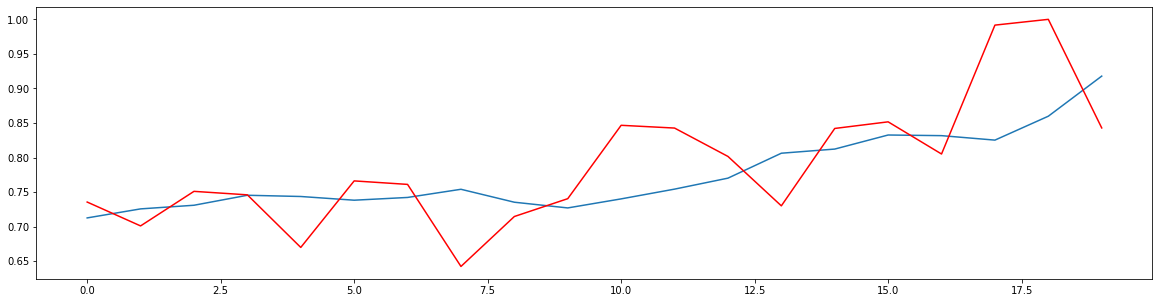

In [ ]:
# plot

plt.figure(figsize=(20,5))
plt.plot(lstm_pred)
plt.plot(Y_test.values, color='red')
plt.show()

In [ ]:
X_train_series.shape[1]

5

In [ ]:
import math
subsequences = 2
timesteps = math.ceil(X_train_series.shape[1]/subsequences)
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], 1, 5, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], 1, 5, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)


Train set shape (96, 1, 5, 1)
Validation set shape (11, 1, 5, 1)


In [ ]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=adam)

In [ ]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)

Epoch 1/100
3/3 - 2s - loss: 0.1663 - val_loss: 0.1716 - 2s/epoch - 613ms/step
Epoch 2/100
3/3 - 0s - loss: 0.1515 - val_loss: 0.1542 - 49ms/epoch - 16ms/step
Epoch 3/100
3/3 - 0s - loss: 0.1360 - val_loss: 0.1368 - 43ms/epoch - 14ms/step
Epoch 4/100
3/3 - 0s - loss: 0.1201 - val_loss: 0.1198 - 47ms/epoch - 16ms/step
Epoch 5/100
3/3 - 0s - loss: 0.1055 - val_loss: 0.1019 - 42ms/epoch - 14ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0888 - val_loss: 0.0826 - 66ms/epoch - 22ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0715 - val_loss: 0.0625 - 55ms/epoch - 18ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0532 - val_loss: 0.0430 - 76ms/epoch - 25ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0353 - val_loss: 0.0259 - 47ms/epoch - 16ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0208 - val_loss: 0.0132 - 47ms/epoch - 16ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0101 - val_loss: 0.0072 - 78ms/epoch - 26ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0059 - val_loss: 0.0081 - 75ms/epoch - 25ms/step
Epoch 13/100
3/3 - 0s - loss: 0.0066 -

In [ ]:
X_test_series_sub = X_test_series.reshape((X_test_series.shape[0], 1, 5, 1))
cnn_lstm_pred = model_cnn_lstm.predict(X_test_series_sub)

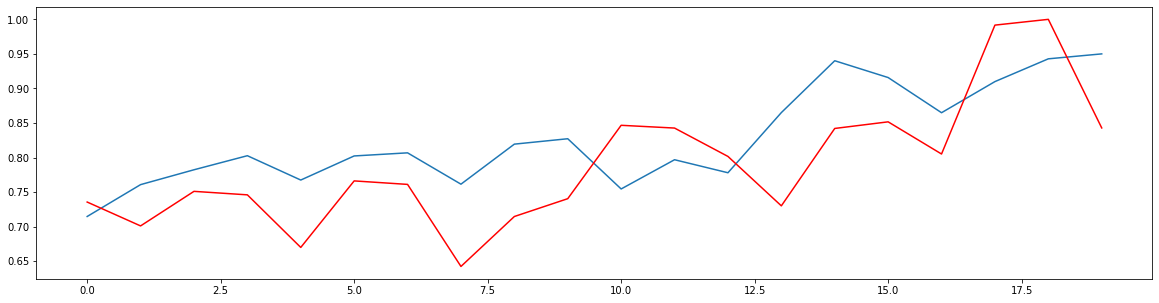

In [ ]:
# plot

plt.figure(figsize=(20,5))
plt.plot(cnn_lstm_pred)
plt.plot(Y_test.values, color='red')
plt.show()